<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Big Data II - Armazenamento
Caderno de **Aula**<br> 
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Introdução;</li>
  <li>Orientação a coluna;</li>
  <li>Particionamento.</li>
</ol>

---

# **Aulas**

## 1\. Introdução

### **1.1. Armazenamento distribuído** 

A escala horizontal de recursos faz com que os dados sejam armazenados em arquivos (`csv`, `txt`, `parquet`, etc.), "quebrados" em blocos (128 MB geralmente) e **distribuídos** e **replicados** (três vezes geralmente) entre os nós do cluster. O gerenciador de *cluster* mantem um mapa da distribuição dos blocos. Esta característica de sistemas distribuídos é abstraída dos usuários comuns de um *cluster*.

### **1.2. Orientação a coluna** 

Tradicionalmente, os sistemas de armazenamento de dados (arquivos, bases de dados, etc.) trabalham com **orientação a linha**, ou seja, para acessar o valor de uma coluna, primeiro encontra-se sua linha. Como exemplo, imagine uma base de dados de vendas de jogos eletrônicos com a seguinte estrutura.

In [ ]:
%%writefile jogos.csv
"id","nome","plataforma","ano_lancamento","total_vendas_mm"
100,"Final Fantasy VII","PSX",1997,12.3
101,"Final Fantasy VIII","PSX",1999,9.6
102,"Final Fantasy IX","PSX",2000,5.5

Writing jogos.csv


A consulta SQL abaixo primeiro encontraria a linha com o `id` igual a 102 para então acessar o valor de 5.5 na coluna `total_vendas_mm`.

```sql
SELECT total_vendas_mm FROM jogos WHERE id = 102 
```

Portanto, no formato **orientado a linha**, consultas com métricas de **agregação** faz com que o acesso ao dado da coluna a ser agregada também seja extraído linha a linha. Como exemplo, a consulta SQL abaixo seria equivalente ao código Python também abaixo:

```sql
SELECT SUM(total_vendas_mm) FROM jogos
```

In [ ]:
import csv
from functools import reduce

vals = []
lines = None

with open('jogos.csv', mode='r') as fp:
  lines = csv.reader(fp)
  next(lines, None)
  for line in lines:
    vals.append(float(line[4]))

sum_vals = reduce(lambda x, y: x + y, vals)

print(sum_vals)

27.4


Em geral, para o volume das bases de dados modernas, essa abordagem é inviável. Para lidar com essa situação, foram criados tipos de arquivos (`Apache Parquet`), bases de dados (`Apache HBase`) e estruturas de dados (`Apache Arrow`) **orientados a colunas**, onde os dados são "pivotados", ou seja, dados de uma mesma coluna são organizados como se estivessem em mesma linha. Portanto, a mesma consulta SQL (replicada abaixo) realizada em um sistema **orientado a colunas** executaria muito mais rápido.

```sql
SELECT SUM(total_vendas_mm) FROM jogos
```

> Sistemas **orientados a colunas** são ideias para **agregações** (base de cargas analíticas).

Vamos explorar o `Apache Parquet` e o `Apache Arrow` na aula 2.

### **1.3. Particionamento** 

Dados são armazenados em uma estrutura de pastas, conhecidas como partições, de tal forma que apenas os dados nas partições de interesse são acessados. Como exemplo, imagine uma base de dados de entregas de um aplicativo de entrega de comidas com a seguinte estrutura:

In [ ]:
%%writefile entrega.csv
"id_entrega","id_resturante","cidade","estado","data"
100,24,"Piracicaba","SP",2022-01-01
101,25,"Piracicaba","SP",2022-01-01
102,26,"Campinas","SP",2022-01-02
103,27,"Florianopolis","SC",2022-01-02
104,28,"Florianopolis","SC",2022-01-03

Writing entrega.csv


Particionar a base por `data` geraria três partições: `2022-01-01`, `2022-01-02` e `2022-01-03`. O efeito no sistema de arquivos seria equivalente ao resultado da execução do código abaixo. Note que a operação "move" a coluna de particionamento `data` dos arquivos `csv` para a estrutura de pastas.

> **Nota**: Não se preocupe em entender o código `bash` abaixo, os pacotes Python de interesse abstraem essa complexidade. 

In [ ]:
!mkdir ./entregas
!mkdir ./entregas/data=2022-01-01
!mkdir ./entregas/data=2022-01-02
!mkdir ./entregas/data=2022-01-03

!echo "id_entrega,id_resturante,cidade,estado" >> ./entregas/data=2022-01-01/entregas_part1.csv
!echo "100,24,Piracicaba,SP" >> ./entregas/data=2022-01-01/entregas_part1.csv
!echo "101,25,Piracicaba,SP" >> ./entregas/data=2022-01-01/entregas_part1.csv

!echo "id_entrega,id_resturante,cidade,estado" >> ./entregas/data=2022-01-02/entregas_part2.csv
!echo "102,26,Campinas,SP" >> ./entregas/data=2022-01-02/entregas_part2.csv
!echo "103,27,Florianopolis,SC" >> ./entregas/data=2022-01-02/entregas_part2.csv

!echo "id_entrega,id_resturante,cidade,estado" >> ./entregas/data=2022-01-03/entregas_part3.csv
!echo "104,28,Florianopolis,SC" >> ./entregas/data=2022-01-03/entregas_part3.csv

Logo, a consulta SQL abaixo retornaria apenas o conteúdo do arquivo `csv` da pasta `data=2022-01-02`, reduzindo assim o tráfego de dados pela rede de computadores que conecta os nós do clusters, o que se traduz em velocidade na consulta (e redução do preço caso esteja usando serviços de computação em nuvem como o AWS Athena).

```sql
SELECT * FROM entregas WHERE "data" = DATE '2022-01-02' 
```

É possível o particionamento em multinível também. Como exemplo, um particionamento por `data` e `estado` geraria uma estrutura de pastas equivalente ao resultado da execução do código abaixo. Note que desta vez tanto a coluna `data` como a coluna `estado` são "movidas" dos arquivos `csv` para a estrutua de pastas.

> **Nota**: Não se preocupe em entender o código `bash` abaixo, os pacotes Python de interesse abstraem essa complexidade. 

In [ ]:
!mkdir ./entregas_multi
!mkdir ./entregas_multi/data=2022-01-01
!mkdir ./entregas_multi/data=2022-01-01/estado=SP
!mkdir ./entregas_multi/data=2022-01-02
!mkdir ./entregas_multi/data=2022-01-02/estado=SP
!mkdir ./entregas_multi/data=2022-01-02/estado=SC
!mkdir ./entregas_multi/data=2022-01-03
!mkdir ./entregas_multi/data=2022-01-03/estado=SC

!echo "id_entrega,id_resturante,cidade" >> ./entregas_multi/data=2022-01-01/estado=SP/entregas_part1.csv
!echo "100,24,Piracicaba" >> ./entregas_multi/data=2022-01-01/estado=SP/entregas_part1.csv
!echo "101,25,Piracicaba" >> ./entregas_multi/data=2022-01-01/estado=SP/entregas_part1.csv

!echo "id_entrega,id_resturante,cidade" >> ./entregas_multi/data=2022-01-02/estado=SP/entregas_part2.csv
!echo "102,26,Campinas" >> ./entregas_multi/data=2022-01-02/estado=SP/entregas_part2.csv

!echo "id_entrega,id_resturante,cidade" >> ./entregas_multi/data=2022-01-02/estado=SC/entregas_part3.csv
!echo "103,27,Florianopolis" >> ./entregas_multi/data=2022-01-02/estado=SC/entregas_part3.csv

!echo "id_entrega,id_resturante,cidade" >> ./entregas_multi/data=2022-01-03/estado=SC/entregas_part4.csv
!echo "104,28,Florianopolis" >> ./entregas_multi/data=2022-01-03/estado=SC/entregas_part4.csv

Logo, a consulta SQL abaixo retornaria apenas o conteúdo do arquivo `csv` da pasta `estado=SC` dentro da pasta `data=2022-01-02`, diminuindo ainda mais o trafego de dados na rede de computadores do cluster mas aumentando o processameno necessário para "varrer" as pastas do sistema de arquivos.

```sql
SELECT * FROM entregas WHERE "data" = DATE '2022-01-02' AND estado = 'SC'
```

> Portanto, as escolha das colunas de partição é uma escolha de compromisso entre **tráfego** (custo) e **velocidade** (processamento).

Colunas como `id_entrega` ou ainda `id_resturante` seriam escolhas infelizes pois gerariam muitas partições com arquivos com poucas linhas.

> **Dica**: Em geral, colunas de tempo no formato YYYY-MM-DD é uma escolha razoável.

> **Dica**: Se possível, demais colunas de partição (além das que remetem ao tempo) devem ser selecionadas de acordo com o padrão de consulta dos dados. Contudo, é muito improvável prever esse tipo de padrão com uma boa assertividade.

Vamos explorar técnicas de particionamento (e orientação a coluna) na nuvem da AWS com o AWS S3 e AWS Athena na aula 3.

## 2\. Orientação a coluna

Para obsevar os benefícios que a orientação a coluna trás para o armazenamento de grandes volumes de dados, vamos explorar duas tecnologias orientadas a colunas: o formato de arquivo `Apache Parquet` (disco) e a estrutura de dados `Apache Arrow` (memória). Vamos também compará-las com seus pares orientados a linha, como arquivos do tipo `csv` e o pacote Python Pandas.  

Como exemplo, vamos utilizar os dados de crime da cidade de Chicago, Estados Unidos da América, em 2014. Os dados estão armazenados em um arquivo no formato `csv` de aproimadamente 50MB e foram extraídos do Kaggle ([link](https://www.kaggle.com/yamqwe/chicago-crimee?select=chicago_crime_2014.csv)).

In [ ]:
!wget https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/crime.csv -q -O crime.csv

Vamos criar um DataFrame Pandas com os dados.

In [ ]:
import pandas as pd

filename = './crime'

df = pd.read_csv(f'./{filename}.csv')

In [ ]:
df.head()

,index,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude
0,0,9446824,HX100141,01/01/2014 02:00:00 AM,0000X W ILLINOIS ST,0460,BATTERY,SIMPLE,STREET,False,False,1831,18,42.0,8.0,08B,41.890828,-87.630235
1,1,9446748,HX100020,01/01/2014 12:00:00 AM,006XX N DEARBORN ST,0890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,1832,18,42.0,8.0,06,41.893542,-87.629702
2,2,9446758,HX100030,01/01/2014 12:30:00 AM,052XX W RACE AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,1523,15,28.0,25.0,14,41.890046,-87.756333
3,3,9446760,HX100027,01/01/2014 12:30:00 AM,053XX W WELLINGTON AVE,0460,BATTERY,SIMPLE,APARTMENT,True,False,2514,25,31.0,19.0,08B,41.935011,-87.759739
4,4,9446764,HX100054,01/01/2014 12:10:00 AM,014XX W LEXINGTON ST,0460,BATTERY,SIMPLE,STREET,False,False,1231,12,25.0,28.0,08B,41.872509,-87.663069


Vamos então conferir alguns metadados do DataFrame.

In [ ]:
df.shape

(274423, 18)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274423 entries, 0 to 274422
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   index                 274423 non-null  int64  
 1   ID                    274423 non-null  int64  
 2   Case Number           274423 non-null  object 
 3   Date                  274423 non-null  object 
 4   Block                 274423 non-null  object 
 5   IUCR                  274423 non-null  object 
 6   Primary Type          274423 non-null  object 
 7   Description           274423 non-null  object 
 8   Location Description  274247 non-null  object 
 9   Arrest                274423 non-null  bool   
 10  Domestic              274423 non-null  bool   
 11  Beat                  274423 non-null  int64  
 12  District              274423 non-null  int64  
 13  Ward                  274421 non-null  float64
 14  Community Area        274422 non-null  float64
 15  

Por fim, vamos realizar uma agregação para futura comparação. Nela, vamos contar a frequencia de ocorrência dos crimes agrupados localidades da cidade (coluna `Location Description`).

In [ ]:
agg_df = df['Location Description'].value_counts()

In [ ]:
agg_df

STREET                     63057
RESIDENCE                  43139
APARTMENT                  35041
SIDEWALK                   30901
OTHER                      10735
                           ...  
GAS STATION DRIVE/PROP.        1
BASEMENT                       1
VESTIBULE                      1
NURSING HOME                   1
GOVERNMENT BUILDING            1
Name: Location Description, Length: 119, dtype: int64

### **2.1. Apache Parquet**

O `Apache Parquet` é o formato de arquivo **orientado a coluna** mais utilizado no ecossistema de *big data* ([documentação](https://parquet.apache.org/)). Entre suas funcionalidades, podemos destacar:

  - indexação por coluna (processamento);
  - tipagem por coluna (processamento e armazenamento);
  - compressão por coluna (armazenamento).

A interoperabilidade com o pacote Python `Pandas` é alcançada atrás do uso de estruturas de dados **orientadas a coluna**, como o `Apache Arrow`. Exemplos:

 - Salvar um `Pandas` DataFrame para um arquivo `Apache Parquet`:

In [ ]:
df.to_parquet('./crime.parquet', engine='pyarrow')

 - Salvar um `Pandas` DataFrame para um arquivo `Apache Parquet` comprimido:

In [ ]:
df.to_parquet('./crime.parquet.gzip', engine='pyarrow', compression='gzip')

Vamos utilizar o método `getsize` do pacote nativo `os` para estimar o tamanho dos arquivos na memória persistente (ROM/SSD):

In [ ]:
import os

extensions = ['csv', 'parquet', 'parquet.gzip']

for extension in extensions:

  size = os.path.getsize(f'{filename}.{extension}')
  size_mb = round(size / 1024 / 1024, 2)

  print(f'{extension}: {size_mb} MB')

csv: 44.72 MB
parquet: 11.66 MB
parquet.gzip: 8.32 MB


### **2.2. Apache Arrow**

O `Apache Arrow` é o uma estrutura de dados **orientado a coluna** muito utilizada no ecossistema de *big data* ([documentação](https://arrow.apache.org/)). É equivalente ao `Apache Parquet`, mas em memória, como listas, dicionários e objetos Python. O pacote Python `PyArrow` ([documentação](https://arrow.apache.org/docs/python/install.html)) permite a criação e manipulação das estruturas de dados do `Apache Arrow`. 

In [ ]:
!pip install pyarrow==7.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.7 MB 1.3 MB/s 
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 6.0.1
    Uninstalling pyarrow-6.0.1:
      Successfully uninstalled pyarrow-6.0.1


O `PyArrow` trabalha com uma estrutura de dados orientada a coluna conhecida como `table` (tabela), similar aos DataFrames `Pandas`.

In [ ]:
from pyarrow import csv
import pyarrow as pa
import pandas as pd

filename = './crime'

table = csv.read_csv(f'{filename}.csv')
df = pd.read_csv(f'./{filename}.csv')

In [ ]:
table.shape

(274423, 18)

In [ ]:
table

pyarrow.Table
index: int64
ID: int64
Case Number: string
Date: string
Block: string
IUCR: string
Primary Type: string
Description: string
Location Description: string
Arrest: bool
Domestic: bool
Beat: int64
District: int64
Ward: double
Community Area: double
FBI Code: string
Latitude: double
Longitude: double
----
index: [[0,1,2,3,4,5,6,7,8,9,...,6187,6188,6189,6190,6191,6192,6193,6194,6195,6196],[6197,6198,6199,6200,6201,6202,6203,6204,6205,6206,...,12348,12349,12350,12351,12352,12353,12354,12355,12356,12357],[12358,12359,12360,12361,12362,12363,12364,12365,12366,12367,...,18491,18492,18493,18494,18495,18496,18497,18498,18499,18500],[18501,18502,18503,18504,18505,18506,18507,18508,18509,18510,...,24631,24632,24633,24634,24635,24636,24637,24638,24639,24640],[24641,24642,24643,24644,24645,24646,24647,24648,24649,24650,...,30765,30766,30767,30768,30769,30770,30771,30772,30773,30774],[30775,30776,30777,30778,30779,30780,30781,30782,30783,30784,...,36895,36896,36897,36898,36899,36900,36901

A similaridade com o Pandas fica evidente quando realizamos operações de agregação.

 - Pandas

In [ ]:
agg_df = df['Location Description'].value_counts()

In [ ]:
agg_df

 - PyArrow

In [ ]:
agg_table = table.group_by('Location Description').aggregate([('Location Description', 'count')])

In [ ]:
agg_table

Vamos utilizar o método `getsizeof` do pacote nativo `sys` para estimar o tamanho dos objetos na memória de trabalho (RAM):

In [ ]:
import sys

objects = [{'pandas': df}, {'pyarrow': table}]

for obj_dict in objects:
  for id, obj in obj_dict.items():
    
    size = sys.getsizeof(obj)
    size_mb = round(size / 1024 / 1024, 2)

    print(f'{id}: {size_mb} MB')

pandas: 160.85 MB
pyarrow: 49.47 MB


Vemos que o objeto gerado pelo `PyArrow` (`table`) é aproximadamente 3 vezes menor que o objeto (`dataframe`) utilizado `Pandas`.

## 3\. Particionamento

Para obsevar os benefícios que o **particionamento** trás para o armazenamento de grandes volumes de dados, vamos explorar as técnicas de particionamento na *cloud* da AWS, utilizando os serviços AWS S3 e AWS Athena, e o seu efeito combinado com a **orientação a coluna** através do `Apache Parquet`.

### **3.1. Dados**

Vamos criar a coluna `reference_date` a partir da coluna `Date` no formato YYYY-MM-DD e entender se ela será uma boa coluna de partião.

In [ ]:
import pandas as pd

filename = './crime'

df = pd.read_csv(f'./{filename}.csv')

In [ ]:
df.head()

,index,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude
0,0,9446824,HX100141,01/01/2014 02:00:00 AM,0000X W ILLINOIS ST,0460,BATTERY,SIMPLE,STREET,False,False,1831,18,42.0,8.0,08B,41.890828,-87.630235
1,1,9446748,HX100020,01/01/2014 12:00:00 AM,006XX N DEARBORN ST,0890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,1832,18,42.0,8.0,06,41.893542,-87.629702
2,2,9446758,HX100030,01/01/2014 12:30:00 AM,052XX W RACE AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,1523,15,28.0,25.0,14,41.890046,-87.756333
3,3,9446760,HX100027,01/01/2014 12:30:00 AM,053XX W WELLINGTON AVE,0460,BATTERY,SIMPLE,APARTMENT,True,False,2514,25,31.0,19.0,08B,41.935011,-87.759739
4,4,9446764,HX100054,01/01/2014 12:10:00 AM,014XX W LEXINGTON ST,0460,BATTERY,SIMPLE,STREET,False,False,1231,12,25.0,28.0,08B,41.872509,-87.663069


In [ ]:
from datetime import datetime

df['reference_date'] = df['Date'].apply(lambda date: datetime.strptime(date.split(sep=' ')[0], '%m/%d/%Y').strftime('%Y-%m-%d'))

In [ ]:
df.tail()

,index,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude,reference_date
274418,274418,10362481,HY554205,08/15/2014 09:00:00 PM,048XX N CLARK ST,1130,DECEPTIVE PRACTICE,FRAUD OR CONFIDENCE GAME,APARTMENT,False,False,2032,20,46.0,3.0,11,NaN,NaN,2014-08-15
274419,274419,10362558,HY554336,08/31/2014 03:00:00 AM,028XX W 19TH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOSPITAL BUILDING/GROUNDS,False,False,1022,10,12.0,30.0,02,NaN,NaN,2014-08-31
274420,274420,10363233,HY554972,02/20/2014 12:00:00 PM,046XX W NORTH AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,OTHER,False,False,2533,25,37.0,25.0,11,NaN,NaN,2014-02-20
274421,274421,10363368,HY555019,09/02/2014 09:00:00 AM,047XX N BEACON ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,APARTMENT,False,False,1913,19,46.0,3.0,11,NaN,NaN,2014-09-02
274422,274422,10364473,HY556366,12/04/2014 09:00:00 AM,012XX W LUNT AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,APARTMENT,False,False,2431,24,49.0,1.0,11,NaN,NaN,2014-12-04


Uma coluna que separa os dados em grupos bem distribuidos é uma boa candidata a uma coluna de partição. Vamos contar as ocorrências de crimes (logo, linhas) em cada um dos dias da coluna `reference_date` recém criada.

In [ ]:
agg_df = pd.DataFrame(df['reference_date'].value_counts()).sort_index().reset_index()
agg_df = agg_df.rename(columns={'reference_date': 'amount'})
agg_df = agg_df.rename(columns={'index': 'reference_date'})

In [ ]:
agg_df.tail()

,reference_date,amount
360,2014-12-27,716
361,2014-12-28,631
362,2014-12-29,677
363,2014-12-30,570
364,2014-12-31,577


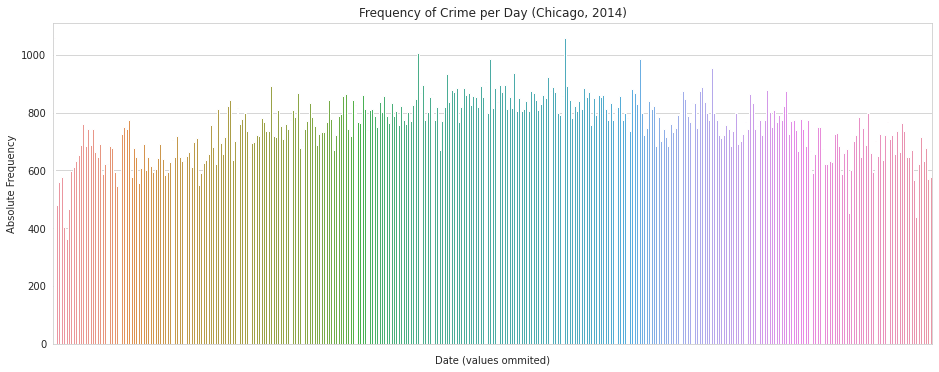

In [ ]:
import seaborn as sns

with sns.axes_style('whitegrid'):

  chart = sns.barplot(x='reference_date', y='amount', data=agg_df)
  chart.set(xticklabels=[])
  chart.set(title='Frequency of Crime per Day (Chicago, 2014)', xlabel='Date (values ommited)', ylabel='Absolute Frequency');
  chart.figure.set_size_inches(w=40/2.54, h=15/2.54)

Observa-se que a coluna `reference_date` de fato divide os dados em grupos equilibrados. Sendo assim, vamos salvar o `DataFrame` Pandas em arquivos comprimidos no formato `Parquet`, particionados pela coluna `reference_date`.

In [ ]:
df.to_parquet('./crimes', engine='pyarrow', compression='gzip', partition_cols='reference_date')

Vamos também salver o `DataFrame` Pandas no formato `CSV` para garantir que os arquivos de ambas as abordagens possuem a coluna `reference_date`.

In [ ]:
df.to_csv('./crime_enriched.csv', sep=',', index=False)

### **3.2. AWS S3**

Na AWS, vamos criar os recursos tanto para o arquivo no formato `csv` quanto para os arquivos no formato `parquet`. 

 - **CSV**

Vamos criar os recursos na AWS:

1. `Bucket` no `AWS S3` para armazenar o arquivo.

 - **Parquet**

Vamos começar criando os recursos na AWS:

1. `Bucket` no `AWS S3` para armazenar os arquivos e suas partições;
1. Usuário no `AWS IAM` para fazer o *upload* dos arquivos e suas partições.

Então, vamos inserir as credenciais no Python.

In [25]:
from getpass import getpass

aws_access_key_id = getpass()

··········


In [26]:
from getpass import getpass

aws_secret_access_key = getpass()

··········


E instalar o pacote Boto3, o SDK Python da AWS.

In [27]:
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 14.3 MB/s 
     |████████████████████████████████| 9.1 MB 62.9 MB/s 
     |████████████████████████████████| 79 kB 8.0 MB/s 
     |████████████████████████████████| 140 kB 69.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.


Por fim, vamos criar o nosso cliente e fazer o *upload* das partições.

In [28]:
import boto3

client = boto3.client(
  's3',
  aws_access_key_id=aws_access_key_id,
  aws_secret_access_key=aws_secret_access_key
)

In [29]:
import os

BUCKET = 'bucket-42-parquet'

i = 0

for root, dirs, files in os.walk('./crimes'):
  elapsed = f'{round(100*i/365, 2)} %'
  print(elapsed)
  for file in files:
    path = os.path.join(root, file)
    bucket_path = '/'.join(path.split(sep='/')[2:])
    client.upload_file(path, BUCKET, bucket_path)
  i = i + 1


0.0 %
0.27 %
0.55 %
0.82 %
1.1 %
1.37 %
1.64 %
1.92 %
2.19 %
2.47 %
2.74 %
3.01 %
3.29 %
3.56 %
3.84 %
4.11 %
4.38 %
4.66 %
4.93 %
5.21 %
5.48 %
5.75 %
6.03 %
6.3 %
6.58 %
6.85 %
7.12 %
7.4 %
7.67 %
7.95 %
8.22 %
8.49 %
8.77 %
9.04 %
9.32 %
9.59 %
9.86 %
10.14 %
10.41 %
10.68 %
10.96 %
11.23 %
11.51 %
11.78 %
12.05 %
12.33 %
12.6 %
12.88 %
13.15 %
13.42 %
13.7 %
13.97 %
14.25 %
14.52 %
14.79 %
15.07 %
15.34 %
15.62 %
15.89 %
16.16 %
16.44 %
16.71 %
16.99 %
17.26 %
17.53 %
17.81 %
18.08 %
18.36 %
18.63 %
18.9 %
19.18 %
19.45 %
19.73 %
20.0 %
20.27 %
20.55 %
20.82 %
21.1 %
21.37 %
21.64 %
21.92 %
22.19 %
22.47 %
22.74 %
23.01 %
23.29 %
23.56 %
23.84 %
24.11 %
24.38 %
24.66 %
24.93 %
25.21 %
25.48 %
25.75 %
26.03 %
26.3 %
26.58 %
26.85 %
27.12 %
27.4 %
27.67 %
27.95 %
28.22 %
28.49 %
28.77 %
29.04 %
29.32 %
29.59 %
29.86 %
30.14 %
30.41 %
30.68 %
30.96 %
31.23 %
31.51 %
31.78 %
32.05 %
32.33 %
32.6 %
32.88 %
33.15 %
33.42 %
33.7 %
33.97 %
34.25 %
34.52 %
34.79 %
35.07 %
35.34 %
35.62 %
35

### **3.3. AWS Athena**

Na AWS, vamos criar os recursos tanto para o arquivo no formato `csv` quanto para os arquivos no formato `parquet`. 

 - **CSV**

Vamos criar os recursos na AWS:

1. Tabela no `AWS Athena` apontando para o arquivo.

```sql
CREATE EXTERNAL TABLE `crime_csv`(
  `index` bigint, 
  `id` string, 
  `case number` string, 
  `date` string, 
  `block` string, 
  `iucr` string, 
  `primary type` string, 
  `description` string, 
  `location description` string, 
  `arrest` string, 
  `domestic` string, 
  `beat` string, 
  `district` string, 
  `ward` string, 
  `community area` string, 
  `fbi code` string, 
  `latitude` string, 
  `longitude` string,
  `reference_date` string)
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.serde2.OpenCSVSerde'
 WITH SERDEPROPERTIES (
   'separatorChar' = ',',
   'quoteChar' = '\"',
   'escapeChar' = '\\'
   )
STORED AS INPUTFORMAT 
  'org.apache.hadoop.mapred.TextInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION
  's3://modulo-42-ebac-csv/'
TBLPROPERTIES (
  "skip.header.line.count"="1")
```

 - **Parquet**

Vamos criar os recursos na AWS:

1. Tabela no `AWS Athena` apontando para os arquivos e suas partições.
1. Carregar as partições.

```sql
CREATE EXTERNAL TABLE `crime_parquet`(
  `index` bigint, 
  `id` bigint, 
  `case number` string, 
  `date` string, 
  `block` string, 
  `iucr` string, 
  `primary type` string, 
  `description` string, 
  `location description` string, 
  `arrest` boolean, 
  `domestic` boolean, 
  `beat` bigint, 
  `district` bigint, 
  `ward` double, 
  `community area` double, 
  `fbi code` string, 
  `latitude` double, 
  `longitude` double)
PARTITIONED BY ( 
  `reference_date` string)
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://modulo-42-ebac-parquet/'
```

```sql
MSCK REPAIR TABLE `crime_parquet`;
```

Por fim, vamos executar um conjunto de consultas SQL em ambas as tabelas e observar a quantidade de dados escaneados.

 - Efeito da **orientação a coluna**:

```sql
SELECT "location description", COUNT(1) as "amount"
FROM crime_csv
GROUP BY 1
ORDER BY 2 DESC;
```

```sql
SELECT "location description", COUNT(1) as "amount"
FROM crime_parquet
GROUP BY 1
ORDER BY 2 DESC;
```

A consulta escaneou 47.34 MB para a tabela `crime_csv`, que é o mesmo tamanho do arquivo, logo um *full scan*. Já para a tabeka `crime_parquet`, a consulta escaneou 0.44 MB. Ou seja, a tabela com o dado **orientado a coluna** escaneou **108 vezes** menos dados para a consulta SQL que seu par em `csv`. 

 - Efeito do **particionamento**:

```sql
SELECT *
FROM crime_csv
WHERE CAST(reference_date as DATE) BETWEEN DATE '2014-12-01' and DATE '2014-12-31'
```

```sql
SELECT *
FROM crime_parquet
WHERE CAST(reference_date as DATE) BETWEEN DATE '2014-12-01' and DATE '2014-12-31'
```

A consulta escaneou 47.34 MB para a tabela `crime_csv`, que é o mesmo tamanho do arquivo, logo um *full scan*. Já para a tabeka `crime_parquet`, a consulta escaneou 1.00 MB. Ou seja, a tabela com o dado **particionado** escaneou **47.34 vezes** menos dados para a consulta SQL que seu par em `csv`. 

 - Efeito da **orientação a coluna** e do **particionamento**:

```sql
SELECT "location description", COUNT(1) as "amount"
FROM crime_csv
WHERE CAST(reference_date as DATE) BETWEEN DATE '2014-12-01' and DATE '2014-12-31'
GROUP BY 1
ORDER BY 2 DESC
```

```sql
SELECT "location description", COUNT(1) as "amount"
FROM crime_parquet
WHERE CAST(reference_date as DATE) BETWEEN DATE '2014-12-01' and DATE '2014-12-31'
GROUP BY 1
ORDER BY 2 DESC
```

A consulta escaneou 47.34 MB para a tabela `crime_csv`, que é o mesmo tamanho do arquivo, logo um *full scan*. Já para a tabeka `crime_parquet`, a consulta escaneou 0.04 MB. Ou seja, a tabela com o dado **particionado** e **orientado a coluna** escaneou **1183.5 vezes** menos dados para a consulta SQL que seu par em `csv`. 